# #1 Initialization of the MNIST data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# load MNIST dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy as np
    path = os.path.join(os.getcwd(), 'data')
    if not os.path.exists(path):
        os.makedirs(path)
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[16:].reshape((-1, 28, 28))
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[16:].reshape((-1, 28, 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28)
(60000,)


Random subset starting at element 8169


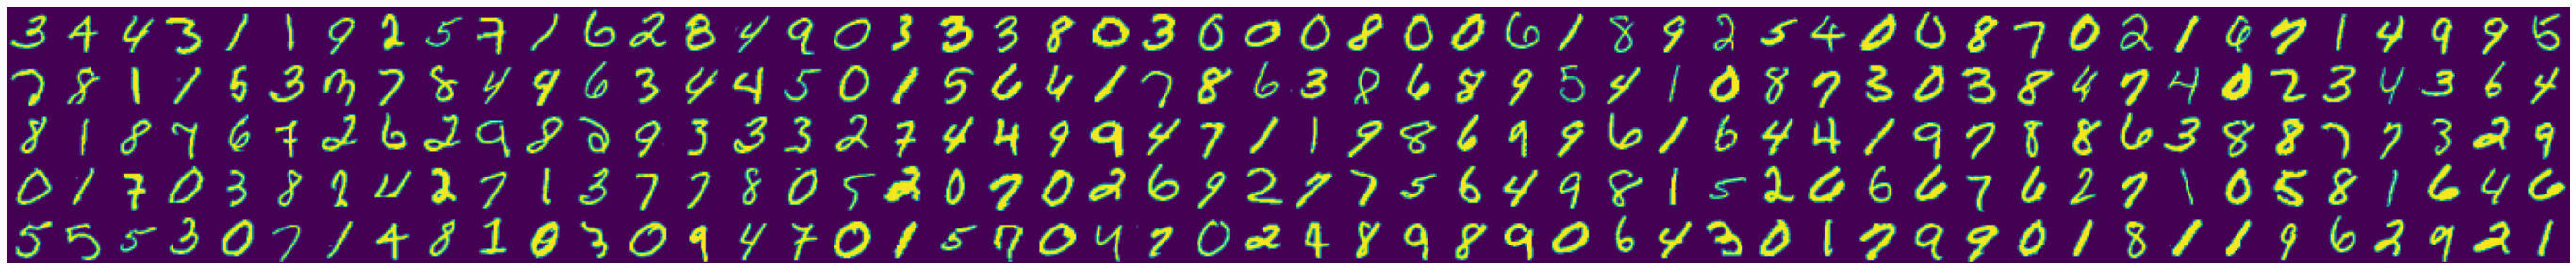

In [3]:
# display (random) subset

SHOW_X = 50
SHOW_Y = 5
S_START = np.random.randint(0, len(X_train)-SHOW_X*SHOW_Y)
grid = X_train[S_START:S_START+SHOW_X*SHOW_Y]
plt.figure(figsize=(SHOW_X, SHOW_Y))
plt.imshow(np.concatenate(grid.reshape((SHOW_X, 28*SHOW_Y, 28)), axis=1))
plt.axis("off")


print(f'Random subset starting at element {S_START}')

# #2 Definition of NN layer types
### Notation
x represents the input of a neuron, y the output. e.g....
* x goes in, y goes out in the forward pass
* gy is the gradient going in, gx the gradient going out in the backward pass

In [4]:
class Layer:
    def forward(self, x):
        '''forward pass--input/output are stored in the layer'''
        raise NotImplementedError

    def backward(self, gy):
        '''backward pass--incoming gradients are stored in the layer'''
        raise NotImplementedError

    def update(self, alpha):
        '''update weights according to learning rate alpha'''

In [5]:
class Linear():
    def __init__(self, input_dim, output_dim, seed=None):
        # TODO: functions for different weight inits
        # Initialize weights with the He initializer
        rnd = np.random.RandomState(seed).randn(input_dim, output_dim)
        self.w = rnd * (2 / input_dim)
        
        # Initialize bias with zeros
        self.b = np.zeros(output_dim)
        
    def forward(self, x):
        # forward propagation y = weight * x + bias
        self.x = x
        y = x.dot(self.w) + self.b
        self.y = y
        return y
    
    def backward(self, gy):
        # backward propagation gradient_out = w * gradient_in
        self.gy = gy
        gx = gy.dot(self.w.T)
        return gx
         
    def update(self, alpha):
        dW = self.x.T.dot(self.gy) / len(self.gy) 
        dB = self.gy.sum(axis=0) / len(self.gy)
        self.w = self.w - alpha * dW 
        self.b = self.b - alpha * dB
        


# #3 Activation functions

In [6]:
class ReLU(Layer):
    def forward(self, x):
        # y = x, if x greater than zero; y = 0, if x smaller than zero
        y = x * (x > 0)
        self.y = y
#         print(f'{y}')
        return y

    def backward(self, gy):
        # gradient_out = dy * gradient_in
        gx = gy * (self.y > 0)
        return gx

    
    
class Sigmoid():
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    def backward(self, gy):
        gx = gy * (1.0 - gy)
        return gx
    
    
class TanH():
    def forward(self, x):
        y = np.tanh(x)
        return y
    
    def backward(self, gy):
        gx = 1.0 - np.tanh(gy)**2
        return gx

    
class SoftMax():  
    def forward(self, x):
        # https://cs231n.github.io/linear-classify/#softmax
        x -= np.max(x)
        y = np.exp(x) / np.sum(np.exp(x))
        return y
    
    def backward(self, gradient_in):
        # gradient_out = dy * gradient_in
        # TODO
        pass
    
    
class LogSoftMax():
    def forward(self, x):
        # logsoftmax = log(e^{…}) - log [sum_k e^{…, class_k, …}]
        # TODO
        pass
        return y
    
    def backward(self, gradient_in):
        # gradient_out = dy * gradient_in
        # TODO
        pass
        return gradient_out



# #4 NN creation

In [7]:
# create neural net

class NN:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, x): 
        # perform forward pass through the network 
        for layer in self.layers:
            x = layer.forward(np.array(x)) # make sure forwarded matrices are numpy arrays
        return x

    def backward(self, gy):
        # perform backward pass through the network
        for layer in reversed(self.layers):
            gy = layer.backward(gy)

        
    def train(self, x, target, alpha):
        # train one batch
        gy = self.forward(x) - target  # Assumes quadratic loss function
        self.backward(gy)
        
        # Update weights in all layers
        for layer in self.layers:
            layer.update(alpha)


In [8]:
# alpha lin. 0.04-0.005; BS 32; MSE < 11 in about 5:57 min in 6 epochs; Loss 7.49/7.84 in 100, 1:42:16
autoencoder1 = NN([Linear(784, 512), 
                  ReLU(), 
                  Linear(512, 16), 
                  Linear(16, 512), 
                  ReLU(), 
                  Linear(512, 784)])

# Fastest per epoch / fastest under 8 MSE
# alpha lin. 0.05-0.005; BS 32; MSE < 11 in about 6:22 min in 9 epochs; Loss 7.50/7.81 in 100, 1:01:15
autoencoder2 = NN([Linear(784, 256), 
                  ReLU(),
                  Linear(256, 128),
                  ReLU(),
                  Linear(128, 16),
                  Linear(16, 128),
                  ReLU(),
                  Linear(128, 256),
                  ReLU(),
                  Linear(256, 784),])

# choose encoder
autoencoder = autoencoder2

In [9]:
# hyper parameters
BS = 32
epochs = 10

# normalize
_max = np.max(X_train)
training_set = X_train / _max
np.random.shuffle(training_set)
validation_set = X_test / _max

# exclude one random batch from training
exclude = BS
rand_subset_start = np.random.randint(0, len(X_train))
no_train = training_set[rand_subset_start:rand_subset_start+exclude]
training_set = np.concatenate([training_set[:rand_subset_start], training_set[rand_subset_start+exclude:]])

  0%|          | 0/10 [00:00<?, ?it/s]

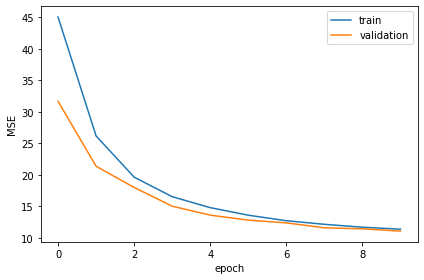

In [10]:

# decrease alpha lineary per batch
alpha_start = 0.04
alpha_end = 0.005
step_size = (alpha_start - alpha_end) / epochs / len(X_train)
alpha = np.flip(np.arange(alpha_end, alpha_start, step_size))
s = 0



losses = np.empty((epochs, 2))
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:
        running_loss = 0.0
        for batch in training_set.reshape(-1, BS, 28, 28):
    
            batch = batch.reshape((-1, 28*28))
            autoencoder.train(batch, batch, alpha[s])
            s += 1

            running_loss += np.sum((autoencoder.layers[-1].y - batch)**2)
        
        # Log losses and update progress bar
        train_loss = running_loss/len(X_train)
        validation_loss = np.sum(np.mean((autoencoder.forward(validation_set.reshape(-1, 28*28))-validation_set.reshape(-1, 28*28))**2, axis=0))
        losses[epoch] = [train_loss, validation_loss]
        pbar.set_description(f'Loss {train_loss:.02f}/{validation_loss:.02f}')



# Visualize losses
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label='train')
plt.plot(np.arange(len(losses)), losses[:,1], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.tight_layout()

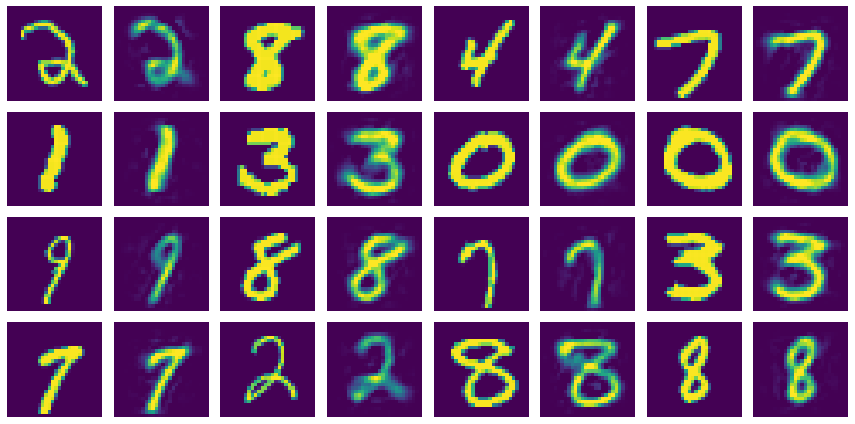

In [11]:
# reconstruct not yet seen data

if exclude >= 16:
    plt_range = 16
else:
    plt_range = exclude

plt.figure(figsize=(12,6))
for i in range(plt_range):
    # show image
    plt.subplot(4,8,2*i+1)
    plt.imshow(no_train[i].reshape((28,28))*_max)
    plt.axis('off')

    # show reconstruction
    # set vmin and vmax as normalized to get clearer colors at the extremes (instead of multiplying by _max) 
    plt.subplot(4,8, 2*i+2)
    plt.imshow(autoencoder.forward(no_train[i].reshape(28*28)).reshape(28,28), vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()